In [1]:
import time
import datetime
import copy
import numpy as np
import math

import pandas as pd
import json
from bson.json_util import dumps
from fastparquet import ParquetFile,write
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

from cm2df import cm2df,precision_recall_fscore_support_metrics2df

In [2]:
pf=ParquetFile('subset_feature_4ML_110619.parq')
udf=pf.to_pandas()

In [3]:
udf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32880 entries, 11049447 to 9968570
Data columns (total 35 columns):
category                 32880 non-null int64
past                     32880 non-null int32
votes                    32880 non-null int64
is_eventbrite            32880 non-null int32
is_free                  32880 non-null int32
doors                    32880 non-null int32
sold_out                 32880 non-null int32
venue.id                 32880 non-null int64
venue.popularity         32880 non-null float64
venue.zip                32880 non-null int64
ticket_allages           32880 non-null int32
ticket_price_low         32880 non-null float64
ticket_price_max         32880 non-null float64
min_age                  32880 non-null int32
artist.popularity.sum    32880 non-null float64
artist.popularity.avg    32880 non-null float64
artist.popularity.max    32880 non-null float64
dow                      32880 non-null int64
doy                      32880 non-null in

In [5]:
usecolsX=['category', 'past', 'is_eventbrite', 'is_free', 'doors',
       'sold_out', 'venue.id', 'venue.popularity', 'venue.zip',
       'ticket_allages', 'ticket_price_low', 'ticket_price_max', 'min_age',
       'artist.popularity.sum', 'artist.popularity.avg',
       'artist.popularity.max', 'dow', 'doy', 'month', 'day', 'hour',
       'venue.tol_num_events', 'duration', 'duration_day', 'multiday']
usecoly1=['votes']
usecoly2=['avg_votes_pday']

In [6]:
udf_X=udf[usecolsX]
udf_y=udf[usecoly1]

In [7]:
# scaling of the features
from sklearn.preprocessing import MinMaxScaler
# scale regression dataset
scalar = MinMaxScaler()
scalar.fit(udf_X)
X = scalar.transform(udf_X)

In [8]:
# create udf_y based on 3 classes: low, mid, high
def get_class(df,thre1,thre2):
    n=len(df)
    newdf=[]
    cut1=min([thre1,thre2])
    cut2=max([thre1,thre2])
    for item in df:
        if item<cut1: newdf+=[0]
        elif (item<cut2) and (item>=cut1):newdf+=[1]
        else: newdf+=[2]
    return newdf

In [14]:
from collections import Counter 

In [81]:
# test on the threshold for classes
arr_lowcut=[10,30,50,80,100,150,200]
arr_highcut=[300,500,700,900,1000,1200,1500]
y=udf_y.values

In [82]:
# print the percentage and numbers out of each pair of thresholds
n=len(y)
for i in arr_lowcut:
    for j in arr_highcut:
        print("low threshold=",i,"high threshold=",j)
        ny=get_class(y,i,j)
        a=Counter(ny)
        print(a)
        print("percentage-wise: low=",round(a[0]/n*100,2),"%,mid=",round(a[1]/n*100,2),"%,high=",round(a[2]/n*100,2),"%")

low threshold= 10 high threshold= 300
Counter({0: 27695, 1: 4975, 2: 210})
percentage-wise: low= 84.23 %,mid= 15.13 %,high= 0.64 %
low threshold= 10 high threshold= 500
Counter({0: 27695, 1: 5067, 2: 118})
percentage-wise: low= 84.23 %,mid= 15.41 %,high= 0.36 %
low threshold= 10 high threshold= 700
Counter({0: 27695, 1: 5117, 2: 68})
percentage-wise: low= 84.23 %,mid= 15.56 %,high= 0.21 %
low threshold= 10 high threshold= 900
Counter({0: 27695, 1: 5141, 2: 44})
percentage-wise: low= 84.23 %,mid= 15.64 %,high= 0.13 %
low threshold= 10 high threshold= 1000
Counter({0: 27695, 1: 5143, 2: 42})
percentage-wise: low= 84.23 %,mid= 15.64 %,high= 0.13 %
low threshold= 10 high threshold= 1200
Counter({0: 27695, 1: 5155, 2: 30})
percentage-wise: low= 84.23 %,mid= 15.68 %,high= 0.09 %
low threshold= 10 high threshold= 1500
Counter({0: 27695, 1: 5161, 2: 24})
percentage-wise: low= 84.23 %,mid= 15.7 %,high= 0.07 %
low threshold= 30 high threshold= 300
Counter({0: 30467, 1: 2203, 2: 210})
percentage-

In [90]:
# ready for the modeling beforehand
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix,classification_report
from sklearn.model_selection import train_test_split


C:\Users\z0043H7B\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\z0043H7B\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\z0043H7B\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\z0043H7B\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-d

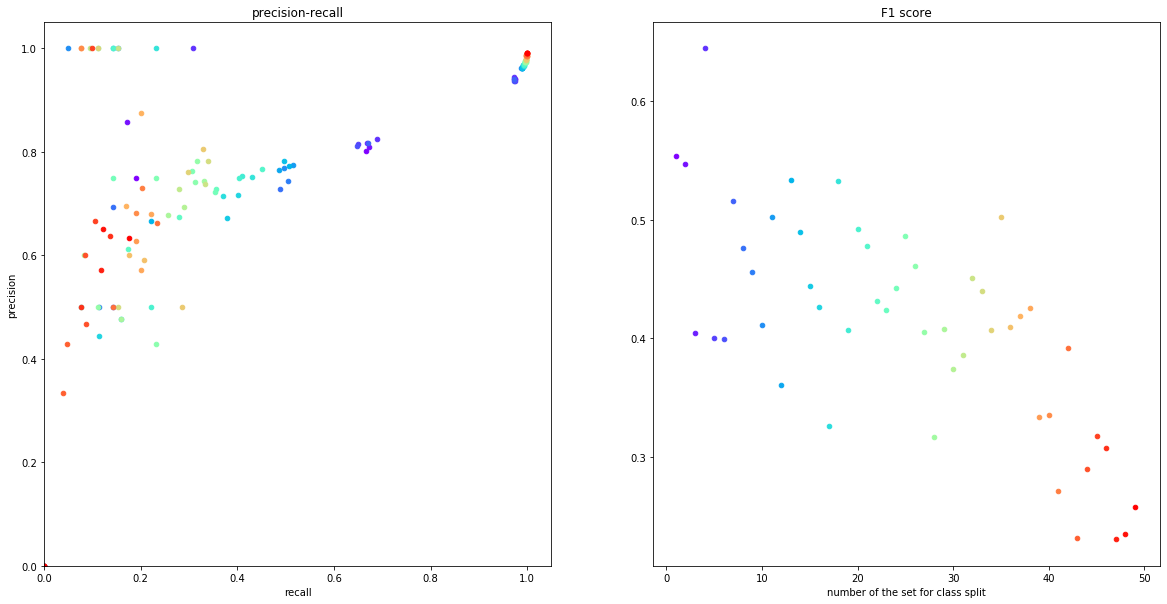

In [125]:
# test on different combination of i,j>> 1)get the correct ydata classes
# 2) feed into train-test split
# 3) test the RF model ,save precision, recall, f1 score
# 4) plot precision, recall to the figure of precision recall plot
# 5) plot the f1 score to f1 tracking heat map
ijmatx=[]
f1matx=np.zeros((7,7))

# set up matplot figure
fig =plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('precision-recall')
ax1.set_xlim([0,1.05])
ax1.set_ylim([0,1.05])
ax1.set_xlabel('recall')
ax1.set_ylabel('precision')
ax2.title.set_text('F1 score')
ax2.set_xlabel('number of the set for class split')
# preset color scale
NUM_COLORS = 49
colors = cm.rainbow(np.linspace(0, 1, NUM_COLORS))
ct=0# counter for colors

n=len(y)
for i,low_cut in enumerate(arr_lowcut):
    for j,high_cut in enumerate(arr_highcut):
        ct+=1
        # get correct ydata classes
        yy=get_class(y,low_cut,high_cut)
        # record the 2 thresholds
        ijmatx+=[(i,j)]
        # setup the model
        X_train, X_test, y_train, y_test = train_test_split(X, yy, test_size=0.3, stratify=yy, random_state=12)
        classifier=RandomForestClassifier(n_estimators=20,random_state=12,verbose=0)
        classifier.fit(X_train,y_train)
        pred_y_test=classifier.predict(X_test)
        # assess the model performance: obtain prescision/recall/f1 scores
        a=precision_recall_fscore_support(y_test, pred_y_test)
        prec=a[0]
        recall=a[1]
        f1s=a[2]
        # create the weighted f1 score: larger emphasis on high-votes bin and medium
        # adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
        adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
        f1matx[i][j]=adjf1
        
        # plot the prec/recall dots to the graph
        s=ax1.scatter(a[1],a[0],s=21, color=colors[ct-1],cmap=cm.rainbow)

        # plot the customized f1 dots to the graph
        s=ax2.scatter(ct,adjf1,s=21, color=colors[ct-1],cmap=cm.rainbow)  

#cbar= plt.colorbar(s)
#cbar.set_label("number count on the set of thresholds", labelpad=+1)

AttributeError: 'PathCollection' object has no attribute 'get_position'

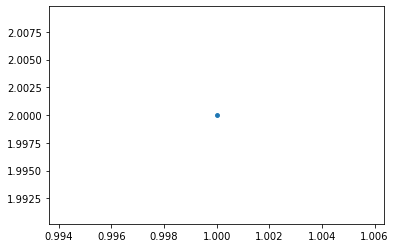

In [136]:

fig.subplots_adjust(bottom=0.5)
ax1=plt.scatter(1,2,s=15,cmap = cm.rainbow)
cb1 = plt.colorbar(ax=ax1, cmap=cm.rainbow)#,orientation='horizontal')
cb1.set_label('Some Units')
fig.show()

In [84]:
fdf = pd.DataFrame(f1matx[:,0], columns=['low_cut_10'])
fdf['low_cut_30']=f1matx[:,1]
fdf['low_cut_50']=f1matx[:,2]
fdf['low_cut_80']=f1matx[:,3]
fdf['low_cut_100']=f1matx[:,4]
fdf['low_cut_150']=f1matx[:,5]
fdf['low_cut_200']=f1matx[:,6]

In [85]:
[300,500,700,900,1000,1200,1500]
fdf['forindex']=['high_cut_300','high_cut_500','high_cut_700','high_cut_900','high_cut_1000','high_cut_1200','high_cut_1500']
fdf=fdf.set_index('forindex')

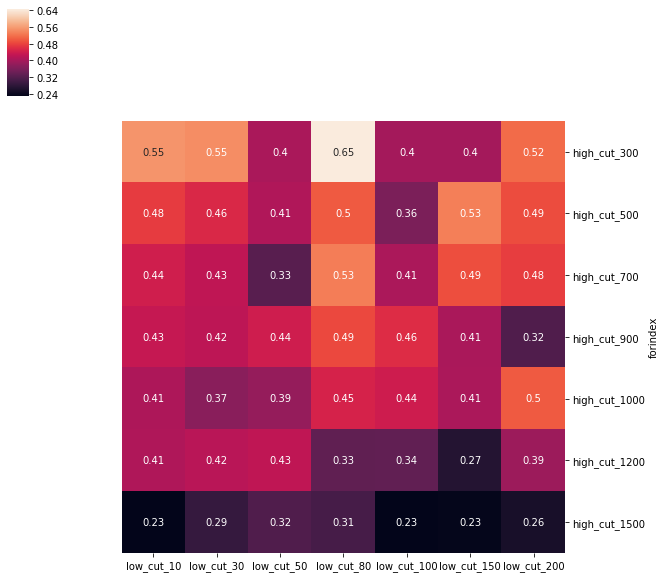

In [86]:
import seaborn as sns
g=sns.clustermap(fdf,annot=True,row_cluster=False,col_cluster=False)

In [87]:
# check out the confusion matrix on the particular case of : low= below 80, mid=between 80 and 300, high => 300
yy=get_class(y,80,300)
# setup the model
X_train, X_test, y_train, y_test = train_test_split(X, yy, test_size=0.3, stratify=yy, random_state=12)
classifier=RandomForestClassifier(n_estimators=20,random_state=12,verbose=0)
classifier.fit(X_train,y_train)
pred_y_test=classifier.predict(X_test)

In [91]:
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9454   27    2]
 [ 224   89    5]
 [  36   16   11]]
other metrics:               precision    recall  f1-score   support

           0       0.97      1.00      0.98      9483
           1       0.67      0.28      0.40       318
           2       0.61      0.17      0.27        63

    accuracy                           0.97      9864
   macro avg       0.75      0.48      0.55      9864
weighted avg       0.96      0.97      0.96      9864



In [92]:
cm_as_df=cm2df(confusion_matrix(y_test, pred_y_test),[0,1,2])
cm_as_df=cm_as_df.rename(columns={0: "pred_0",1: "pred_1", 2: "pred_2"})

In [93]:
cm_as_df.to_csv('CML_Perf/RF_25feat_0p3testnoweights_CM_opthresholds_110819.csv')

In [95]:
# looking at the feature importances
classifier.feature_importances_

array([0.04096516, 0.00211708, 0.00728208, 0.01225646, 0.02864806,
       0.00764622, 0.06366446, 0.0237607 , 0.03494123, 0.01239343,
       0.03689919, 0.02775641, 0.02077103, 0.11727214, 0.08508108,
       0.0922191 , 0.03757164, 0.079414  , 0.04133241, 0.06216914,
       0.04069004, 0.06183735, 0.05912678, 0.00236586, 0.00181892])

category 0.04096516264771347
past 0.002117084773894491
is_eventbrite 0.007282078062128379
is_free 0.012256462829527186
doors 0.028648064168088683
sold_out 0.007646222343971945
venue.id 0.06366445621875558
venue.popularity 0.023760704923464243
venue.zip 0.034941225003518914
ticket_allages 0.012393433551314998
ticket_price_low 0.03689919144567351
ticket_price_max 0.027756410590207725
min_age 0.020771031663308365
artist.popularity.sum 0.11727214260451586
artist.popularity.avg 0.08508108461441793
artist.popularity.max 0.09221910272896243
dow 0.037571641777538654
doy 0.07941400065914657
month 0.041332406735186254
day 0.062169136644801705
hour 0.040690040493503256
venue.tol_num_events 0.061837354208144193
duration 0.059126784905337806
duration_day 0.0023658573896567885
multiday 0.0018189190172210393


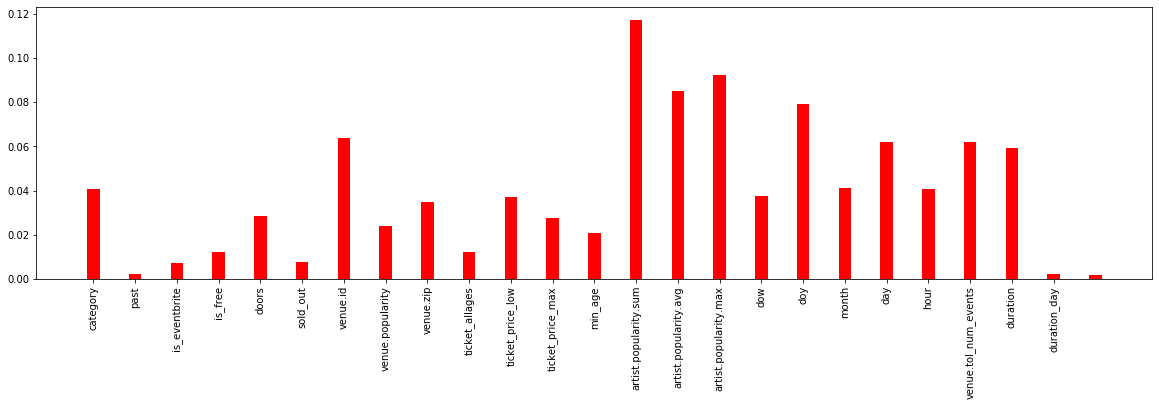

In [97]:
# take a look at feature importance
f_importance = pd.DataFrame({'feature':udf_X.columns, 'importance':classifier.feature_importances_})
#plot histogram
lenc = len(udf_X.columns)
x_tick_label=[None]*lenc
hist_val=np.zeros(lenc)
for i in range(0,lenc):
    hist_val[i] = f_importance.values[i][1]
    x_tick_label[i] = f_importance.values[i][0]
    print(x_tick_label[i],hist_val[i])
    
index = np.arange(lenc)+1
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(index,hist_val, .3, color='r')
ax.set_xticks(range(1, lenc, 1))
ax.set_xticklabels(x_tick_label, rotation='vertical')
plt.show()

In [ ]:
# look at the prediction prbablity
